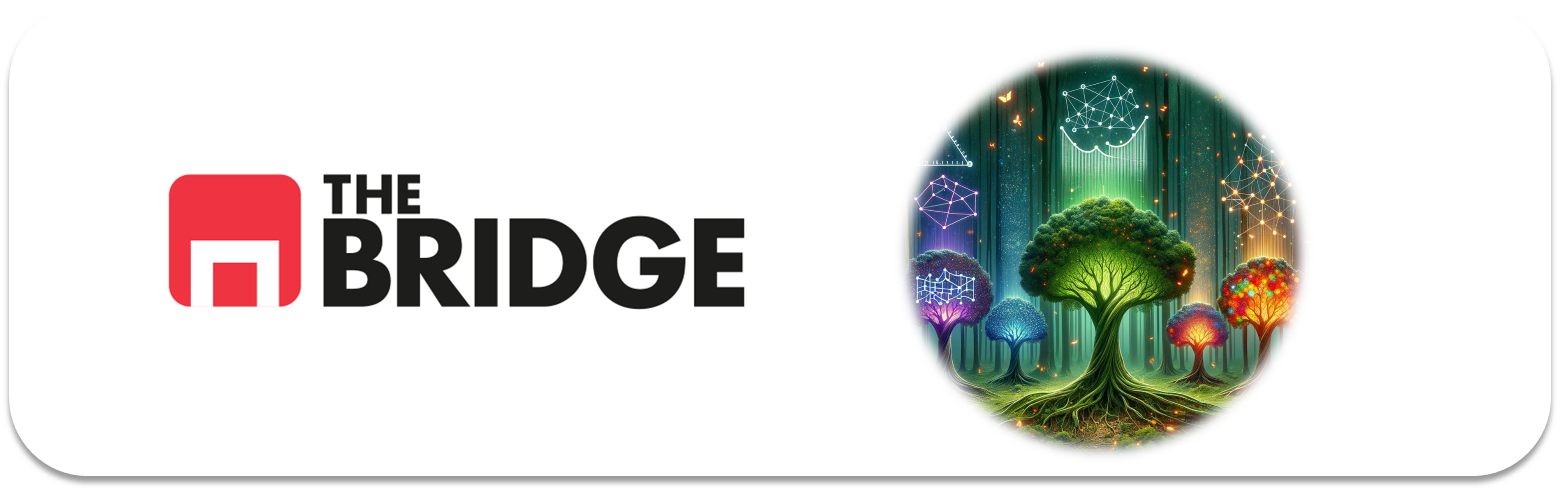

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")    
  17 - y: has the client subscribed a term deposit?(Binary: "yes", "no")

  

### 0. Importar librerias y modulos

In [1]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

from sklearn.tree import DecisionTreeClassifier #implantar objeto arbol
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV    #optimizacion parametros
from sklearn.model_selection import RandomizedSearchCV  #optimizacion de parametros peor
from sklearn.model_selection import train_test_split # realizar el split
from sklearn.linear_model import ElasticNet    #hiperparámetro mixto

Problema de negocio: Predecir si un cliente terminará de pagar un depósito en tiempo. Es decir, si no tardará más de lo acordado.

### 1. Carga Dataset

In [2]:
df=pd.read_csv("./data/bank-full.csv", sep=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 2. Limpieza

``default, housing, loan, y``: nos dicen que son categoricas (object) pero son binarios. Comprobamos la cardinalidad del resto y les haremos una transformacion con el get_dummies más adelante.

In [5]:
def analizar_df(dataframe):
    # Inicializar listas para almacenar información
    columnas = []
    dtypes = []
    cardinalidades = []
    porcentajes = []

    # Iterar sobre las columnas del DataFrame
    for col in dataframe.columns:
        # Obtener el tipo de dato de la columna
        dtype = dataframe[col].dtype

        # Obtener la cardinalidad y porcentaje
        unique_values = dataframe[col].nunique()
        total_values = len(dataframe[col])
        porcentaje = (unique_values / total_values) * 100

        # Almacenar la información en las listas
        columnas.append(col)
        dtypes.append(dtype)
        cardinalidades.append(unique_values)
        porcentajes.append(porcentaje)

    # Crear un DataFrame con la información recopilada
    resultados = pd.DataFrame({
        'Columna': columnas,
        'Tipo': dtypes,
        'Cardinalidad': cardinalidades,
        'Porcentaje de valores únicos': porcentajes
    })

    return resultados

In [6]:
analizar_df(df)

,Columna,Tipo,Cardinalidad,Porcentaje de valores únicos
0,age,int64,77,0.170313
1,job,object,12,0.026542
2,marital,object,3,0.006636
3,education,object,4,0.008847
4,default,object,2,0.004424
5,balance,int64,7168,15.854549
6,housing,object,2,0.004424
7,loan,object,2,0.004424
8,contact,object,3,0.006636
9,day,int64,31,0.068567


In [7]:
# Lista de columnas categóricas con cardinalidad igual a 2
columnas_categoricas_binarias = [col for col in df.select_dtypes(include=['object']).columns
                                  if df[col].nunique() == 2]

# Convertir las columnas categóricas binarias a booleanas
for col in columnas_categoricas_binarias:
    df[col] = df[col].replace({'yes': True, 'no': False}).astype('bool')

# Lista de columnas categóricas mayores de 2 valores
columnas_categoricas = [col for col in df.select_dtypes(include=['object']).columns
                                           if df[col].nunique() > 2]

# Aplicar one-hot encoding a todas las columnas categóricas
df_encoded = pd.get_dummies(df, columns=columnas_categoricas, prefix=columnas_categoricas)

# Mostrar el DataFrame resultante
df_encoded

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,False,2143,True,False,5,261,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
1,44,False,29,True,False,5,151,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
2,33,False,2,True,True,5,76,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
3,47,False,1506,True,False,5,92,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
4,33,False,1,False,False,5,198,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,False,825,False,False,17,977,3,-1,0,...,False,False,False,True,False,False,False,False,False,True
45207,71,False,1729,False,False,17,456,2,-1,0,...,False,False,False,True,False,False,False,False,False,True
45208,72,False,5715,False,False,17,1127,5,184,3,...,False,False,False,True,False,False,False,False,True,False
45209,57,False,668,False,False,17,508,4,-1,0,...,False,False,False,True,False,False,False,False,False,True


In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  bool 
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  bool 
 4   loan                 45211 non-null  bool 
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  bool 
 11  job_admin.           45211 non-null  bool 
 12  job_blue-collar      45211 non-null  bool 
 13  job_entrepreneur     45211 non-null  bool 
 14  job_housemaid        45211 non-null  bool 
 15  job_management       45211 non-null  bool 
 16  job_retired          4

### 3. Train/Test Split

In [9]:
df_encoded.y.value_counts()

y
False    39922
True      5289
Name: count, dtype: int64

*Es un problema supervisado de una sola clase. Además el dataset está bastante desequilibrado en ``no 88% y yes 12%``.*

In [10]:
# split
train_set, test_set = train_test_split(df_encoded, test_size= 0.2, random_state= 42)

In [11]:
# Subdivisiones
X_train=train_set.drop(columns=["y"])
y_train=train_set["y"]
X_test=test_set.drop(columns=["y"])
y_test=test_set["y"]

### 4. Mini-EDA

Analizamos la target ``y``

In [12]:
train_set.y.value_counts()

y
False    31970
True      4198
Name: count, dtype: int64

Es un problema supervisado de una sola clase. Además el dataset está bastante desequilibrado en ``no 88% y yes 12%``.

Text(0.5, 0, 'y')

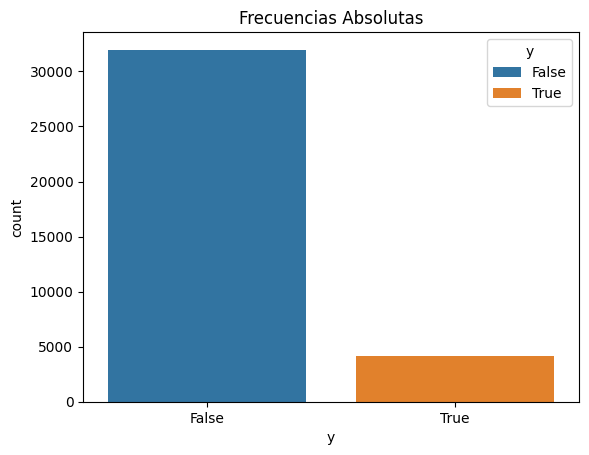

In [13]:
#Frecuencias Absolutas
sns.countplot(x= "y", data = train_set, hue = "y")
plt.title("Frecuencias Absolutas")
plt.xlabel("y")

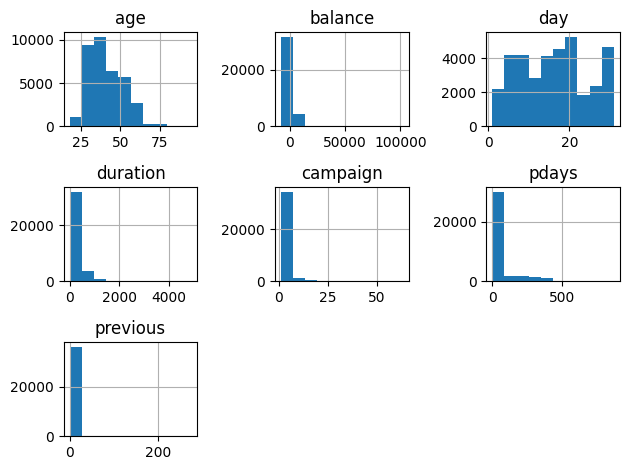

In [14]:
train_set.hist()
plt.tight_layout()
plt.show()

In [15]:
# vemos las correlaciones
corr = np.abs(train_set.corr(numeric_only=True)["y"]).sort_values(ascending = False)
corr

y                      1.000000
duration               0.393402
poutcome_success       0.305084
poutcome_unknown       0.169549
contact_unknown        0.153470
housing                0.140234
contact_cellular       0.136622
month_oct              0.130183
month_mar              0.127642
month_sep              0.124370
pdays                  0.105742
month_may              0.104700
previous               0.092051
month_dec              0.077569
job_retired            0.076440
job_student            0.073606
campaign               0.072571
job_blue-collar        0.071767
month_apr              0.071153
loan                   0.066708
education_tertiary     0.065868
marital_single         0.061856
marital_married        0.059588
balance                0.052518
education_primary      0.039156
poutcome_other         0.035207
education_secondary    0.034721
month_jul              0.032046
month_feb              0.031607
job_management         0.030974
age                    0.026684
day     

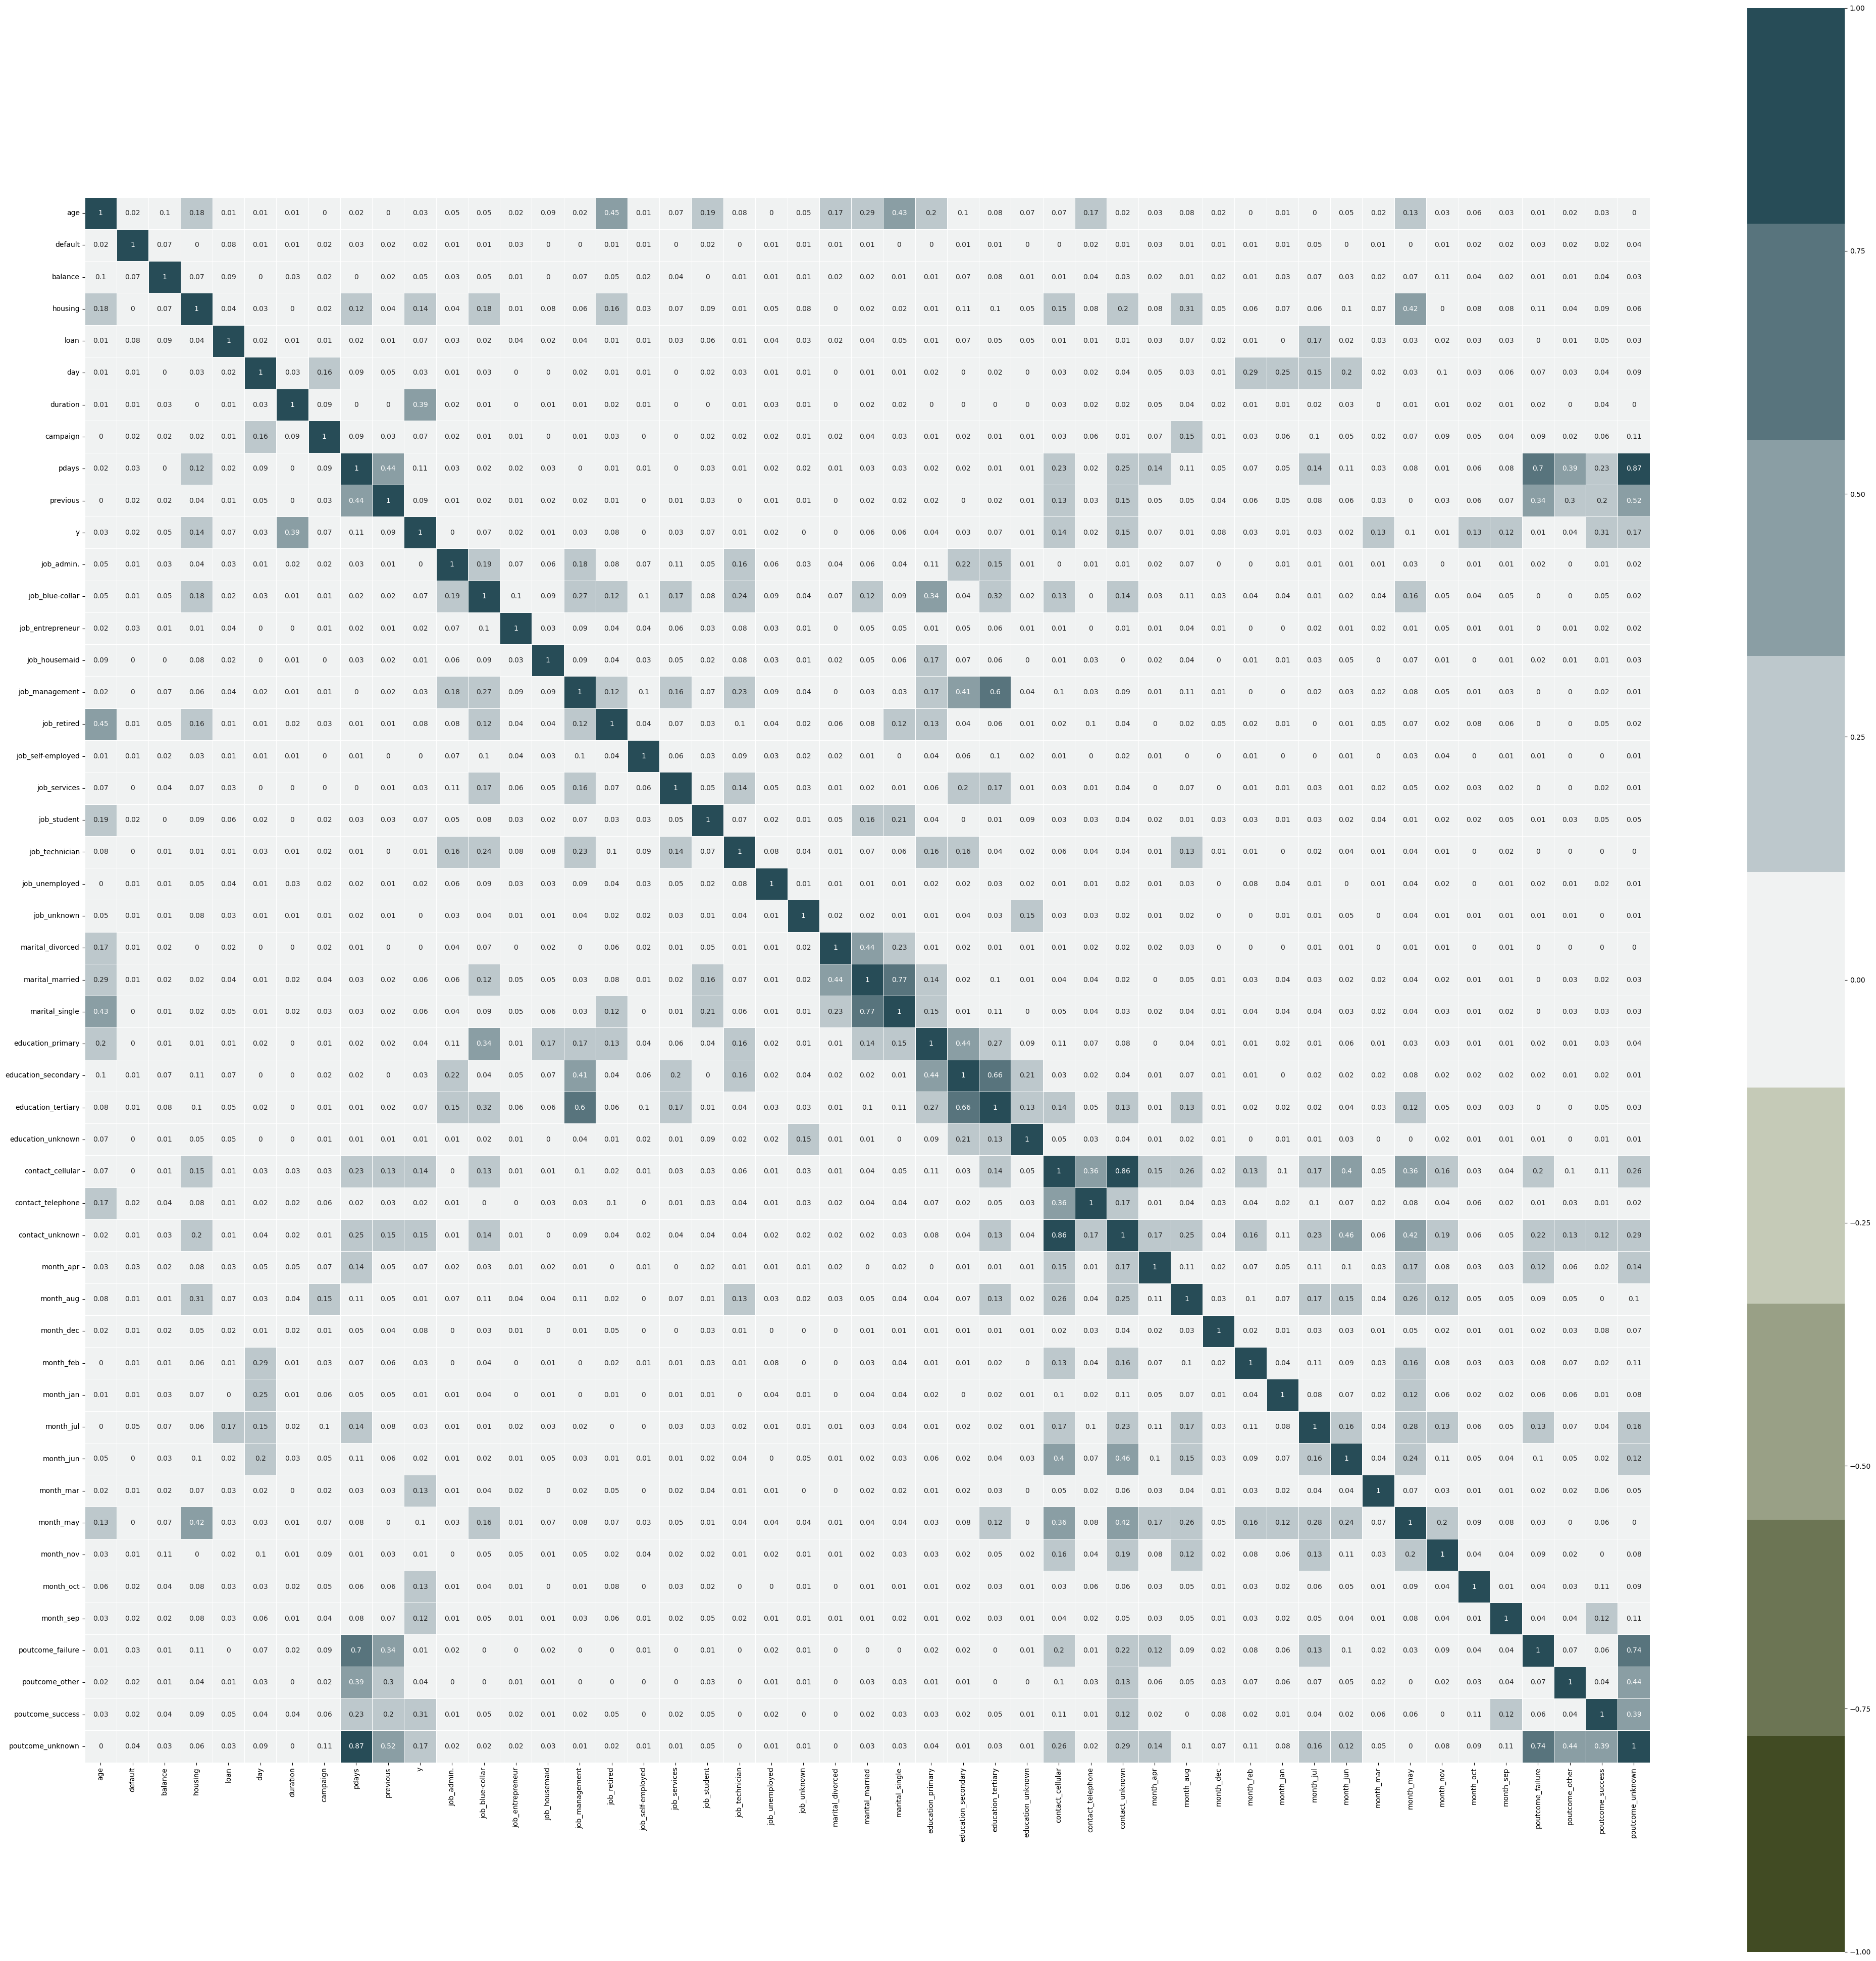

In [16]:
# Mapa de calor
plt.figure(figsize=(50,50))
sns.heatmap(np.round(np.abs(train_set.corr()), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(100, 220, s=70, l=30, n=9),
            square=True,
            linewidths=.5);

In [17]:
corr.nlargest(10)

y                   1.000000
duration            0.393402
poutcome_success    0.305084
poutcome_unknown    0.169549
contact_unknown     0.153470
housing             0.140234
contact_cellular    0.136622
month_oct           0.130183
month_mar           0.127642
month_sep           0.124370
Name: y, dtype: float64

In [18]:
corr.nsmallest(10).sort_values(ascending=False)

poutcome_failure     0.011747
job_housemaid        0.011729
job_technician       0.010275
month_jan            0.009773
education_unknown    0.007343
month_aug            0.006371
job_admin.           0.004291
marital_divorced     0.004099
job_self-employed    0.004072
job_unknown          0.001127
Name: y, dtype: float64

Las 3 que mejor correlan son ``duration, poutcome_success,poutcome_unknown`` y las 3 que peor lo hacen son ``job_unknown,job_self-employed,marital_divorced``

### 5. Entrenamiento y evaluación

In [19]:
#instancio mi objeto 
tree_clf=DecisionTreeClassifier(max_depth=None, max_leaf_nodes= None,
                            random_state=42)

In [20]:
# Entreno el árbol y evalúo contra test, este es mi baseline
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      7952
        True       0.48      0.49      0.48      1091

    accuracy                           0.87      9043
   macro avg       0.70      0.71      0.71      9043
weighted avg       0.87      0.87      0.87      9043



In [21]:
# objeto 2
tree_clf_2=DecisionTreeClassifier(max_depth=3, max_leaf_nodes= 50,
                            random_state=42)

In [22]:
# Entreno el árbol y evalúo contra test
tree_clf_2.fit(X_train,y_train)
y_pred = tree_clf_2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      7952
        True       0.65      0.30      0.41      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



Cambiando hiperparámetros mejoro accuracy, qie ya era alto. Como los valores de recall son los que me importan (porque mi variable presente valores significativamente distintos, y me interesa saber los valores de True para ``y``) voy a utilizar esa metrica para optener mis hiperparametros.

### 6. Optimizo hiperparámetros

Utilizo el metodo grid search ya que quiero encontrar el valor optimo

In [24]:
# datos para optimizacion
param_grid = {
    'max_depth': [1,5,10],
    'max_leaf_nodes': [None, *np.arange(2, 200, 20)],
    'min_samples_leaf': np.arange(1, 21, 5)
}

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='recall') #cv es el crossvalidation

#entreno mi objeto
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
#mejores parametros
grid_search.best_params_

{'max_depth': 10, 'max_leaf_nodes': 52}

In [ ]:
eeeee

NameError: name 'eeeee' is not defined

In [ ]:
grid_search.best_score_

0.4566433963335036

In [ ]:
# R2 en test
grid_search.best_estimator_.score(X_test, y_test)

0.8976003538648678

In [ ]:
# hago prueba
# objeto 3
tree_clf_3=DecisionTreeClassifier(max_depth=10, max_leaf_nodes= 52,
                            random_state=42)

In [ ]:
# Entreno el árbol y evalúo contra test
tree_clf_3.fit(X_train,y_train)
y_pred = tree_clf_3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.96      0.94      7952
        True       0.61      0.42      0.50      1091

    accuracy                           0.90      9043
   macro avg       0.77      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043



La accuracy se mantiene en .90 pero mi recall ...( no se como se interpreta esta parte, anotado para preguntar en clase)

### 7. Visualización

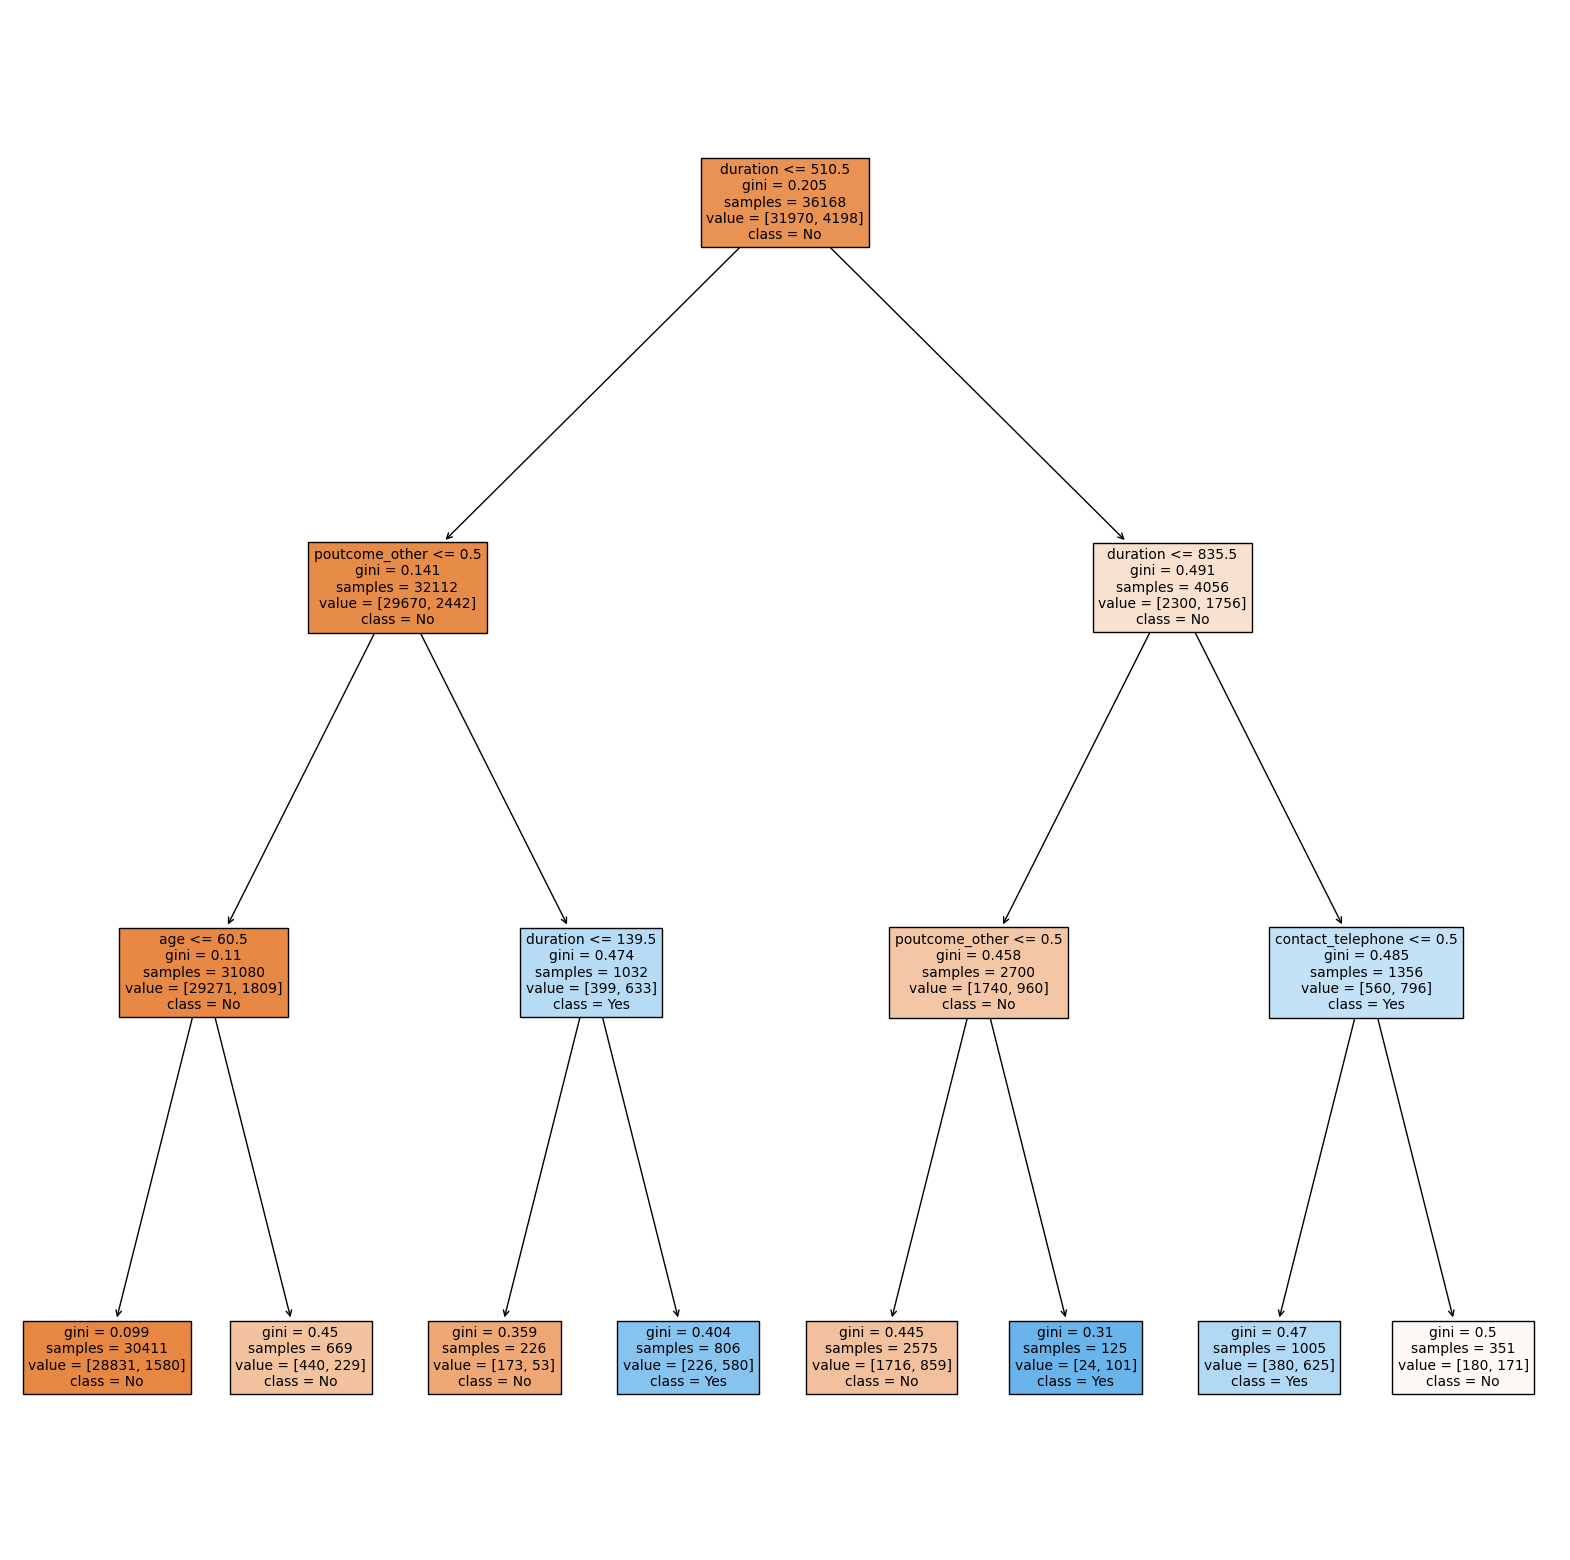

In [ ]:
# arbol baseline
plt.figure(figsize=(50, 50))
plot_tree(tree_clf, feature_names=df_encoded.columns, filled=True, class_names=['No', 'Yes'])
plt.show()

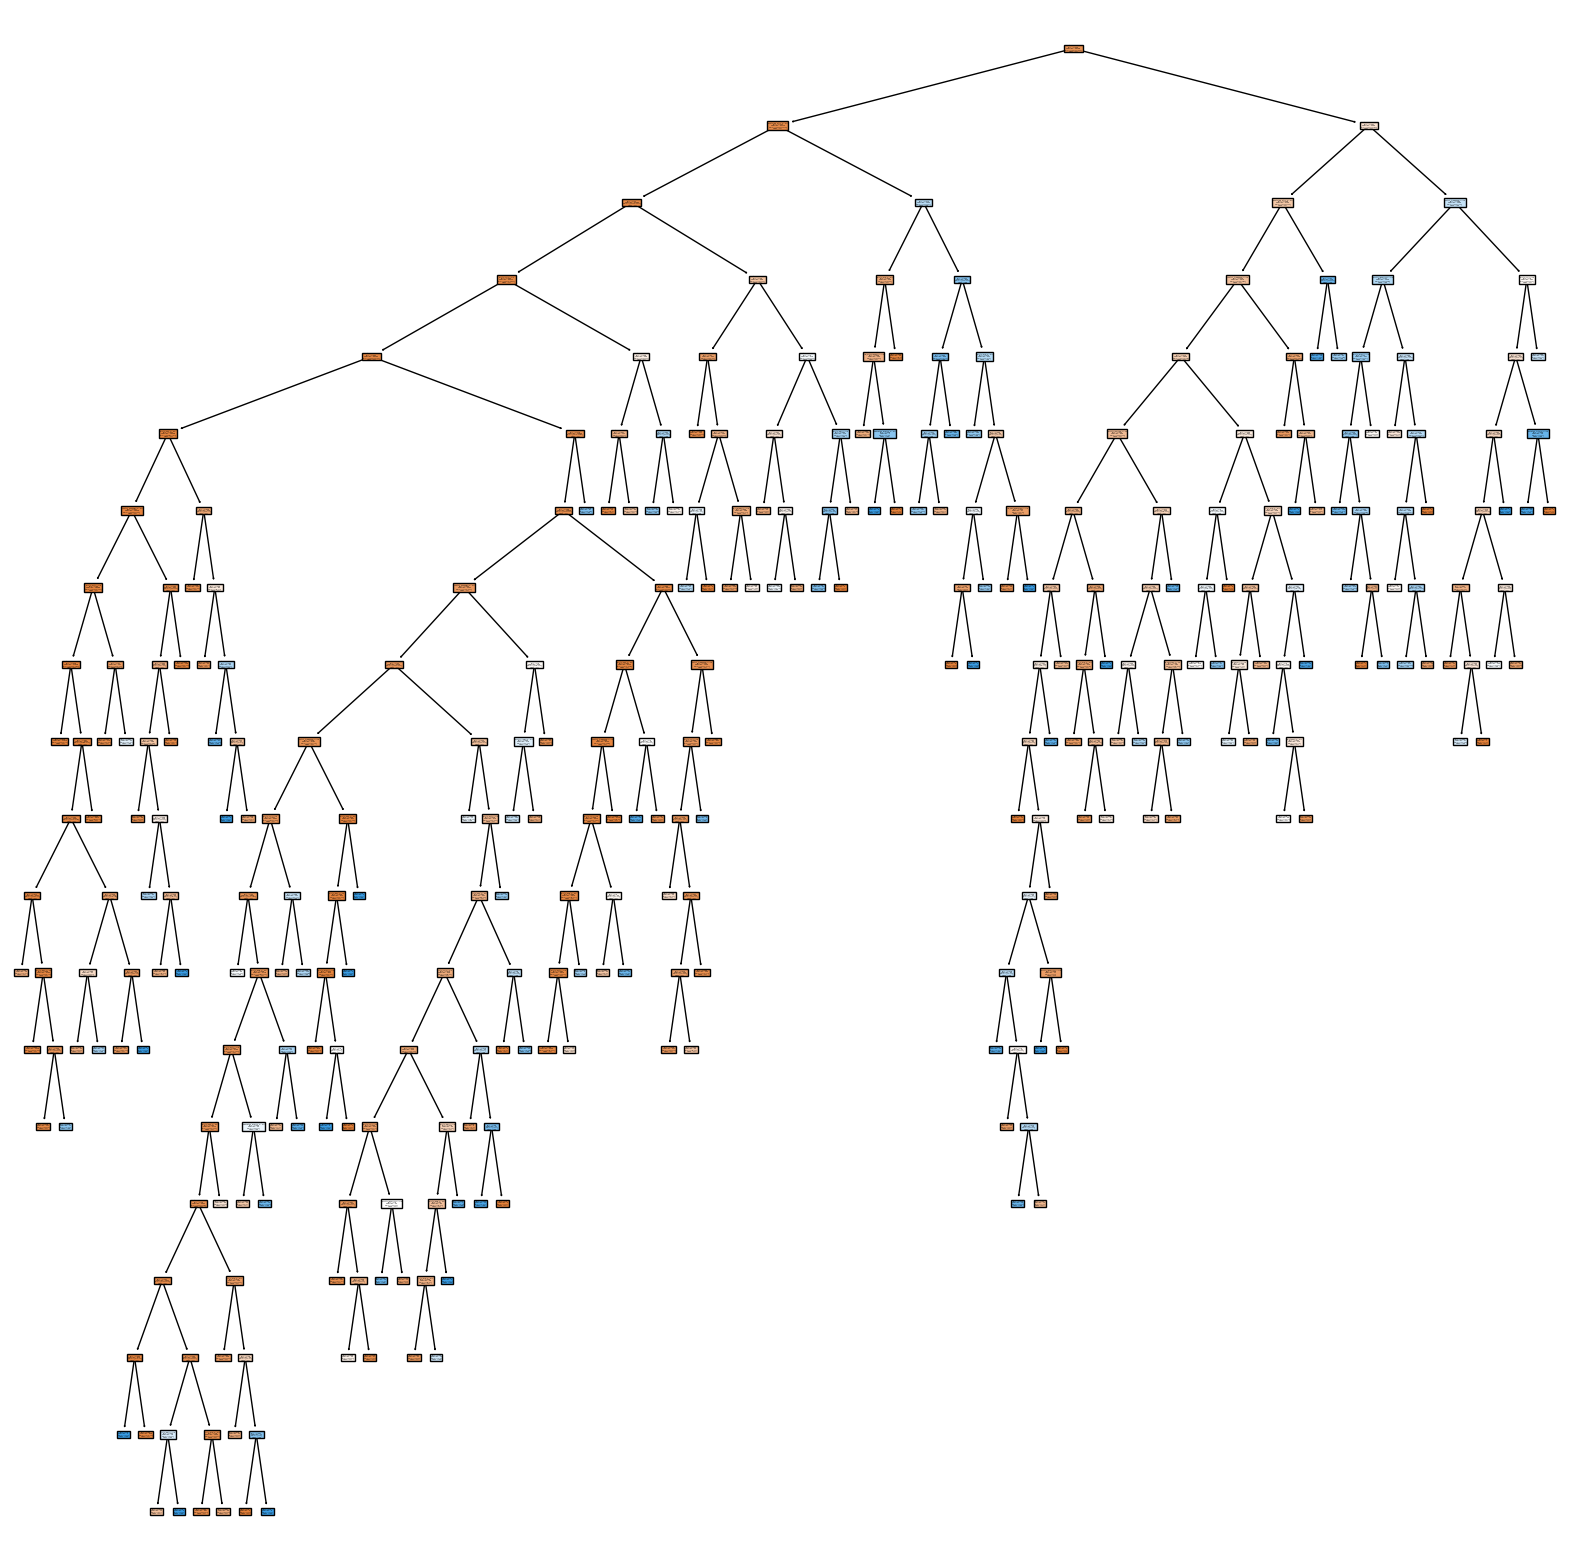

In [ ]:
#arbol con optimizacion de hiperparametros
plt.figure(figsize=(50, 50))
plot_tree(tree_clf_3, feature_names=df_encoded.columns, filled=True, class_names=['No', 'Yes'])
plt.show()